**This question should be answered using PyTorch and MNIST data set as discussed in the class.**

**a) Implement LeNET-5 CNN configuration to predict handwritten digits with high accuracy.**

In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Normalize
import torch.nn.functional as F

# Download training data from open datasets with normalization
transform = Compose([
    ToTensor(),
    Normalize((0.5,), (0.5,))  # Normalize to mean=0.5 and std=0.5
])

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)  # Input: 1x32x32, Output: 6x32x32
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # Output: 6x16x16

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)  # Output: 16x12x12
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # Output: 16x6x6

        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0)  # Output: 120x1x1

        # Fully connected layers
        self.fc1 = nn.Linear(120, 84)  # Fully connected layer
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization
        self.fc2 = nn.Linear(84, num_classes)  # Output layer

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Replaced tanh with ReLU
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)  # Flatten the tensor for fully connected layers

        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        logits = self.fc2(x)

        return logits

model = LeNet().to(device)
print(model)

# Use Adam optimizer with weight decay for regularization
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Using cpu device
LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)
Epoch 1
-------------------------------
loss: 2.305239  [   64/60000]
loss: 0.638245  [ 6464/60000]
loss: 0.428915  [12864/60000]
loss: 0.438203  [19264/60000]
loss: 0.239655  [25664/60000]
loss: 0.301049  [32064/60000]
loss: 0.187294  [38464/60000]
loss: 0.398884  [44864/60000]
loss: 0.323709  [51264/60000]
loss: 0.169689  [57664/60000]
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.111388 

Epoch 2
-----

**b) Demonstrate prediction for some values.**

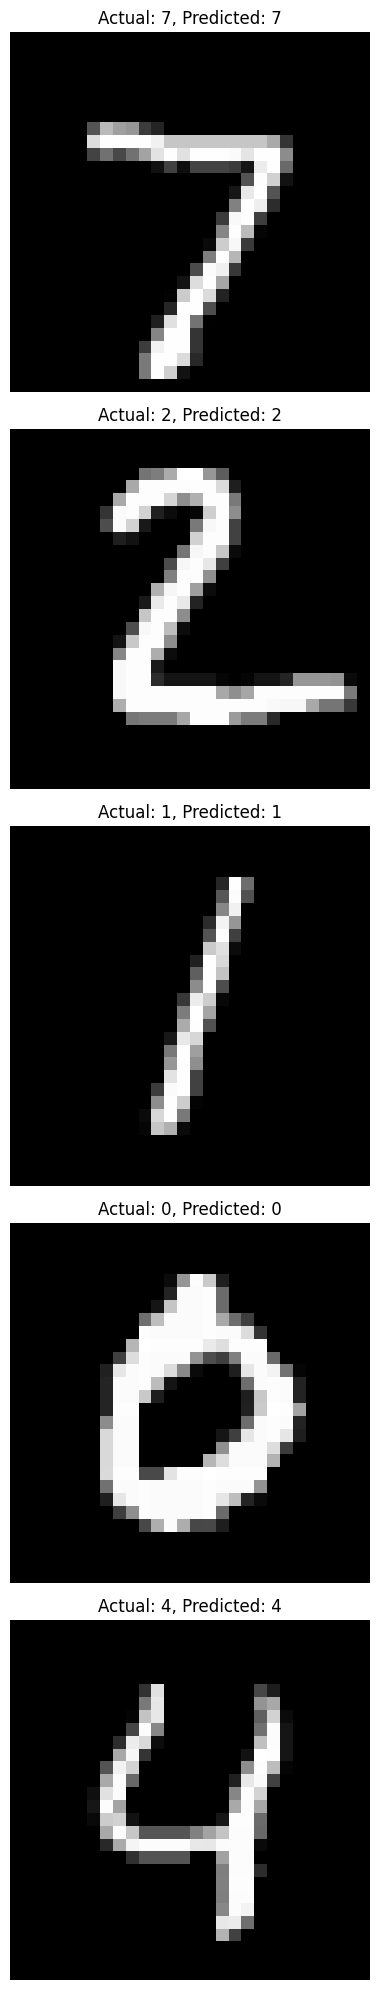

In [9]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()  # Set the model to evaluation mode
sample_images = []
actual_values = []
predicted_values = []

with torch.no_grad():
    for i, (X, y) in enumerate(test_dataloader):
        if i >= 5:  # Take only 5 samples
            break
        X, y = X.to(device), y.to(device)
        pred = model(X)

        for j in range(len(X)):
          sample_images.append(X[j].cpu().numpy().squeeze()) #Added to save images
          actual_values.append(y[j].item())
          predicted_values.append(pred[j].argmax().item())


# Display the results in a tabular format using matplotlib
fig, axes = plt.subplots(5, 1, figsize=(5, 20))

for i in range(5):
    axes[i].imshow(sample_images[i], cmap='gray')
    axes[i].set_title(f"Actual: {actual_values[i]}, Predicted: {predicted_values[i]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()



**c) Display few samples of each layer's feature maps.**

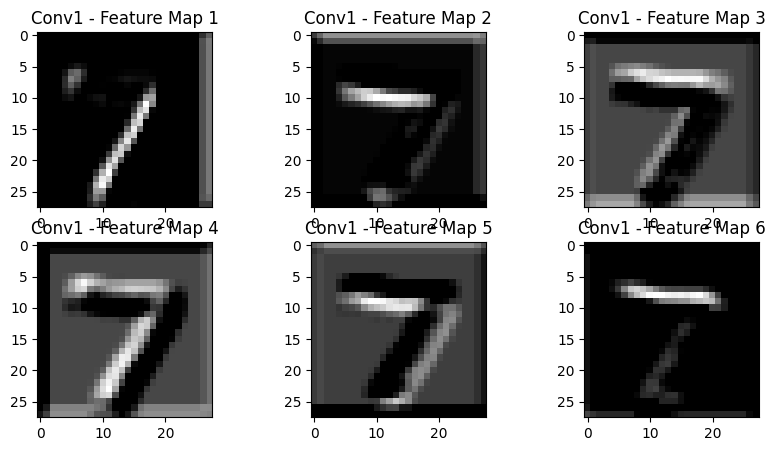

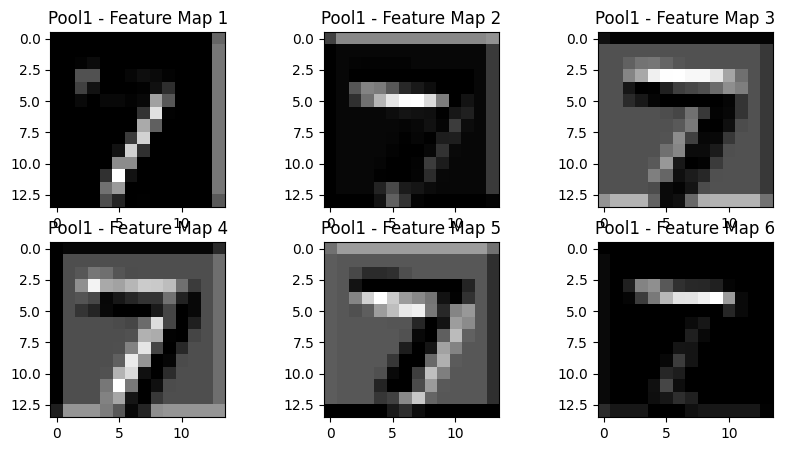

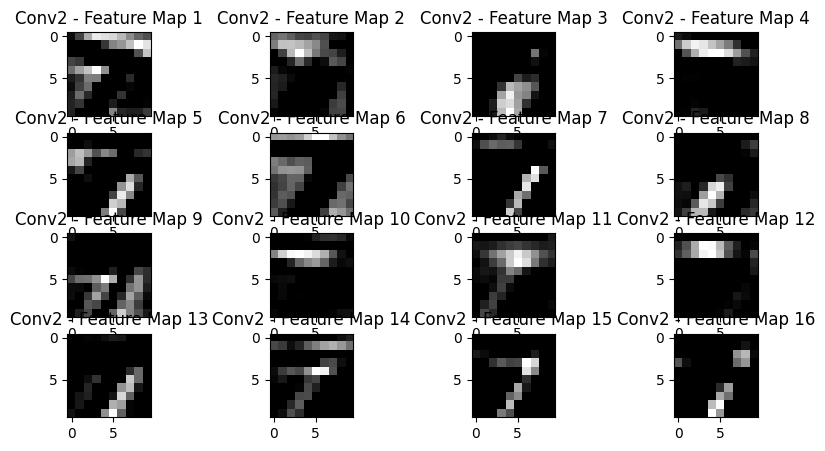

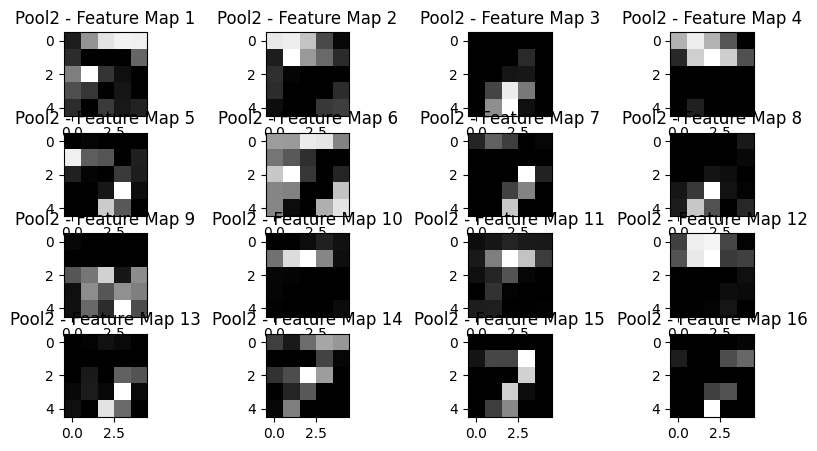

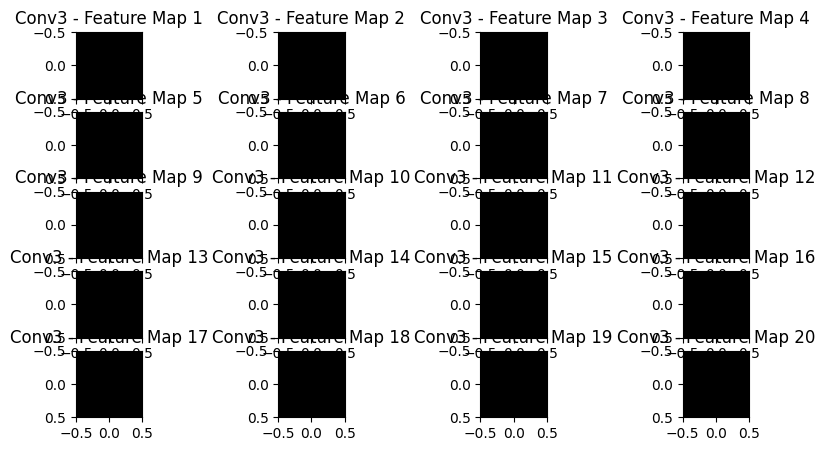

In [14]:
import matplotlib.pyplot as plt
import torch

sample_images_tensor = torch.tensor(sample_images, dtype=torch.float32)

if len(sample_images_tensor.shape) == 3:
    sample_images_tensor = sample_images_tensor.unsqueeze(1)

# Function to visualize feature maps for one sample
def visualize_feature_maps(model, image):
    model.eval()
    with torch.no_grad():
        # Pass the single image through the layers
        image = image.unsqueeze(0).to(device)

        # Visualize Conv1 layer
        x = F.relu(model.conv1(image))
        plt.figure(figsize=(10, 5))
        for j in range(6):  # Conv1 has 6 feature maps
            plt.subplot(2, 3, j + 1)
            plt.imshow(x[0, j, :, :].cpu().numpy(), cmap='gray')
            plt.title(f"Conv1 - Feature Map {j + 1}")
        plt.show()

        # Visualize Pool1 layer
        x = model.pool1(x)
        plt.figure(figsize=(10, 5))
        for j in range(6):
            plt.subplot(2, 3, j + 1)
            plt.imshow(x[0, j, :, :].cpu().numpy(), cmap='gray')
            plt.title(f"Pool1 - Feature Map {j + 1}")
        plt.show()

        # Visualize Conv2 layer
        x = F.relu(model.conv2(x))
        plt.figure(figsize=(10, 5))
        for j in range(16):  # Conv2 has 16 feature maps
            plt.subplot(4, 4, j + 1)
            plt.imshow(x[0, j, :, :].cpu().numpy(), cmap='gray')
            plt.title(f"Conv2 - Feature Map {j + 1}")
        plt.show()

        # Visualize Pool2 layer
        x = model.pool2(x)
        plt.figure(figsize=(10, 5))
        for j in range(16):
            plt.subplot(4, 4, j + 1)
            plt.imshow(x[0, j, :, :].cpu().numpy(), cmap='gray')
            plt.title(f"Pool2 - Feature Map {j + 1}")
        plt.show()

        # Visualize Conv3 layer
        x = F.relu(model.conv3(x))
        plt.figure(figsize=(10, 5))
        for j in range(min(120, 20)):  # Display only the first 20 feature maps for clarity
            plt.subplot(5, 4, j + 1)
            plt.imshow(x[0, j, :, :].cpu().numpy(), cmap='gray')
            plt.title(f"Conv3 - Feature Map {j + 1}")
        plt.show()

# Call the visualization function with the first sample
visualize_feature_maps(model, sample_images_tensor[0])


**d) Print the possible Performance Metrics of the model.**

In [16]:
# prompt: print a confusion matrix and report all possible performance metrics of the model

from sklearn.metrics import confusion_matrix, classification_report

# ... (Your existing code) ...

# **d) Print the possible Performance Metrics of the model.**

model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        predictions = pred.argmax(1).cpu().numpy()  # Get predicted class labels
        labels = y.cpu().numpy()  # Get true class labels
        all_predictions.extend(predictions)
        all_labels.extend(labels)

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Generate the classification report
report = classification_report(all_labels, all_predictions)
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[ 975    0    0    0    0    0    1    1    3    0]
 [   0 1132    0    0    0    0    0    2    1    0]
 [   0    0 1026    3    0    0    0    3    0    0]
 [   0    0    0 1009    0    0    0    1    0    0]
 [   0    1    2    0  959    0    1    1    1   17]
 [   1    0    0   24    0  865    0    1    0    1]
 [   5    3    1    1    1   18  924    0    5    0]
 [   0    1    7    2    0    0    0 1015    0    3]
 [   1    0    3   16    1    1    0    3  944    5]
 [   1    3    1   10    3    1    0    5    2  983]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.95      1.00      0.97      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.97      0.97       892
           6       1.00      0.96      0.98     